In [1]:
import numpy as np
import networkx as nx
import sys
from itertools import product
from variationaltoolkit import VarForm
from variationaltoolkit.utils import mact, get_max_independent_set_operator
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit import Parameter
from variationaltoolkit import VariationalQuantumOptimizerSequential

Can't find the mpsbackend module, continuing without it


[2020-04-03 17:00:22,294] {/home/rshaydu/quantum/variationaltoolkit/variationaltoolkit/__init__.py:19} WARNING - Failed loading VariationalQuantumOptimizerAPOSMM, ignoring the following error: 'No module named 'libensemble''


# Let's solve maximum independent set on this graph

$G = K_{2,3}$

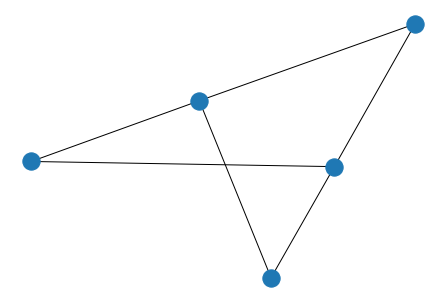

In [2]:
elist = [[0,2],[0,4],[1,2],[1,4],[0,3],[1,3]]
G = nx.OrderedGraph()
G.add_edges_from(elist)
vertex_num = G.number_of_nodes()
w = nx.adjacency_matrix(G, nodelist=range(vertex_num))
nx.draw(G)

In [3]:
def obj(x):
    return -sum(x)

# Set level to INFO to print optimization progress
import logging
from variationaltoolkit.utils import set_log_level
set_log_level(logging.INFO)

# Generate cost Hamiltonian
C, offset = get_max_independent_set_operator(vertex_num)

# First, allocate registers
qu = QuantumRegister(vertex_num)
ancilla_for_multi_toffoli = QuantumRegister(vertex_num - 2)
ancilla_for_rx = QuantumRegister(1)
cu = ClassicalRegister(vertex_num)

# Mixer circuit
beta = Parameter('beta')
mixer_circuit = QuantumCircuit(qu, ancilla_for_multi_toffoli, ancilla_for_rx, cu)
for u in G.nodes():
    mixer_circuit.barrier()
    mact(mixer_circuit, list(qu[x] for x in G.neighbors(u)), ancilla_for_rx, ancilla_for_multi_toffoli)

    mixer_circuit.mcrx(2 * beta, ancilla_for_rx, qu[u])
    mixer_circuit.barrier()

    mact(mixer_circuit, list(qu[x] for x in G.neighbors(u)), ancilla_for_rx, ancilla_for_multi_toffoli)

# Measurement circuit 
measurement_circuit = QuantumCircuit(qu, ancilla_for_multi_toffoli, ancilla_for_rx, cu)
measurement_circuit.measure(qu, cu)

# For the purposes of this example, I've precomputed a good initial point
# You can pass None and it'll generate a random one for you
initial_point = np.array([ 6.04102059,  3.74579808, -5.50077232, -3.18254589, -0.61572468,
         4.51305444, -0.47617092,  5.97028743,  2.51725288, -2.20904592,
        -5.38950718,  2.09493441,  1.23907814, -1.45952838, -3.57838767,
        -3.66236095, -2.67445383,  3.00190345,  2.84712677,  5.13521998])

# pass it all to VariationalQuantumOptimizer
varopt = VariationalQuantumOptimizerSequential(
    obj,
    'COBYLA',
    initial_point=initial_point,
    optimizer_parameters={'maxiter':10},
    backend_description={'package':'qiskit', 'provider':'Aer', 'name':'qasm_simulator'},
    problem_description={'offset': offset},
    varform_description={
        'name':'QAOA',
        'p':10,
        'cost_operator':C,
        'num_qubits':vertex_num, 'use_mixer_circuit':True,
        'mixer_circuit':mixer_circuit,
        'measurement_circuit': measurement_circuit,
        'qregs':[qu, ancilla_for_multi_toffoli, ancilla_for_rx, cu]
    },
    execute_parameters={'shots': 5000}
    )
res = varopt.optimize()

[2020-04-03 17:00:25,140] {/home/rshaydu/quantum/variationaltoolkit/variationaltoolkit/objectivewrapper.py:79} INFO - called at step 0, objective: -2.5444 at point [ 6.04102059  3.74579808 -5.50077232 -3.18254589 -0.61572468  4.51305444
 -0.47617092  5.97028743  2.51725288 -2.20904592 -5.38950718  2.09493441
  1.23907814 -1.45952838 -3.57838767 -3.66236095 -2.67445383  3.00190345
  2.84712677  5.13521998]
[2020-04-03 17:00:27,623] {/home/rshaydu/quantum/variationaltoolkit/variationaltoolkit/objectivewrapper.py:79} INFO - called at step 1, objective: -0.7866 at point [ 7.04102059  3.74579808 -5.50077232 -3.18254589 -0.61572468  4.51305444
 -0.47617092  5.97028743  2.51725288 -2.20904592 -5.38950718  2.09493441
  1.23907814 -1.45952838 -3.57838767 -3.66236095 -2.67445383  3.00190345
  2.84712677  5.13521998]
[2020-04-03 17:00:30,024] {/home/rshaydu/quantum/variationaltoolkit/variationaltoolkit/objectivewrapper.py:79} INFO - called at step 2, objective: -1.623 at point [ 6.04102059  4.745

# Let's look at the optimal parameters and how long it took us to find them

In [4]:
print(res)

{'num_optimizer_evals': 10, 'min_val': -2.5444, 'opt_params': array([ 6.04102059,  3.74579808, -5.50077232, -3.18254589, -0.61572468,
        4.51305444, -0.47617092,  5.97028743,  2.51725288, -2.20904592,
       -5.38950718,  2.09493441,  1.23907814, -1.45952838, -3.57838767,
       -3.66236095, -2.67445383,  3.00190345,  2.84712677,  5.13521998])}


In [5]:
optimum, counts = varopt.get_optimal_solution(return_counts=True)
print(f"Found optimal solution: {optimum}")

# Check that the optimal solution is feasible
for i, j in product(set(np.where(reversed(optimum))[0]), repeat=2):
    if i != j:
        try:
            assert(not G.has_edge(i,j))
        except AssertionError as e:
            print(i,j,x)
            raise e

Found optimal solution: (-3, array([1, 1, 1, 0, 0]))


Counter({'11100': 3528, '01100': 241, '11000': 239, '00011': 233, '00010': 177, '00001': 136, '00000': 126, '01000': 124, '10100': 98, '10000': 52, '00100': 46})


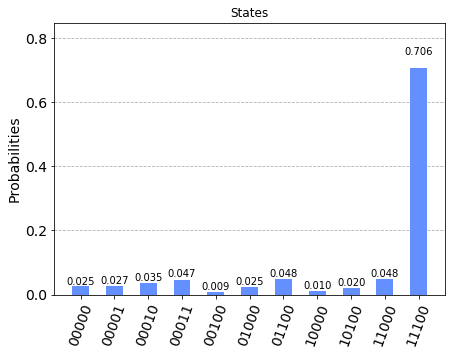

In [8]:
from qiskit.tools.visualization import plot_histogram
print(counts)
plot_histogram(counts, title='States')